<a href="https://colab.research.google.com/github/irivers29/medical-robot/blob/master/model_2_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import fnmatch
from math import atan2, cos, sin, sqrt, pi

%matplotlib inline 
cv.__version__
plt.rcParams['figure.figsize'] = [30, 20]

'4.1.2'

In [ ]:
drive.mount("/content/drive")
!pwd
%cd /content/
%cd drive/MyDrive/summer_school_sdu/
! ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1nkSBip8QBWLlGCjlBgIVPho2kMqJZzYz/summer_school_sdu
/content
/content/drive/.shortcut-targets-by-id/1nkSBip8QBWLlGCjlBgIVPho2kMqJZzYz/summer_school_sdu
'Medical robot doc.gdoc'   medical-robot-repo   output.txt   ROPCA_Vision


In [ ]:
!ls ./ROPCA_Vision/raw/right
print('------------------------------------')
!ls ./ROPCA_Vision/raw/left/
print('------------------------------------')
!ls ./ROPCA_Vision/labeled/right
print('------------------------------------')
!ls ./ROPCA_Vision/labeled/left/

img000080.png  img104072.png  img110044.png  img117041.png  img122073.png
img000081.png  img104073.png  img111040.png  img117042.png  img122074.png
img000082.png  img104074.png  img111041.png  img117043.png  img123040.png
img000083.png  img105040.png  img111042.png  img117044.png  img123041.png
img000084.png  img105041.png  img111043.png  img119070.png  img123042.png
img100080.png  img105042.png  img111044.png  img119071.png  img123043.png
img100081.png  img105043.png  img113040.png  img119072.png  img123044.png
img100082.png  img105044.png  img113041.png  img119073.png  img200080.png
img100083.png  img107070.png  img113042.png  img119074.png  img200081.png
img100084.png  img107071.png  img113043.png  img120040.png  img200082.png
img102040.png  img107072.png  img113044.png  img120041.png  img200083.png
img102041.png  img107073.png  img114070.png  img120042.png  img200084.png
img102042.png  img107074.png  img114071.png  img120043.png  img300080.png
img102043.png  img109040.png  img11407

**Segmentation algorithms:** Compare their segmentation performance for all the images.


1.   Skin detection : HSV color space thresholding
2.   OpenCV: foreground background subtractor
3.   GMM models for segmentation



In [ ]:
#Load Data
def get_all_filenames(folder_name):
  pattern = "img*.png"
  files = sorted(fnmatch.filter(os.listdir(folder_name),pattern))
  return files

data_folders_right = ["./ROPCA_Vision/raw/right",
                "./ROPCA_Vision/labeled/right",
                "./ROPCA_Vision/segmented/right"]
data_folders_left = ["./ROPCA_Vision/raw/left",
                "./ROPCA_Vision/labeled/left",
                "./ROPCA_Vision/segmented/left"]

raw_files_right = get_all_filenames(data_folders_right[0])
labeled_files_right = get_all_filenames(data_folders_right[1])
print(raw_files_right)

raw_files_left = get_all_filenames(data_folders_left[0])
labeled_files_left = get_all_filenames(data_folders_left[1])
print(raw_files_left)


['img000080.png', 'img000081.png', 'img000082.png', 'img000083.png', 'img000084.png', 'img100080.png', 'img100081.png', 'img100082.png', 'img100083.png', 'img100084.png', 'img102040.png', 'img102041.png', 'img102042.png', 'img102043.png', 'img102044.png', 'img103070.png', 'img103071.png', 'img103072.png', 'img103073.png', 'img103074.png', 'img104070.png', 'img104071.png', 'img104072.png', 'img104073.png', 'img104074.png', 'img105040.png', 'img105041.png', 'img105042.png', 'img105043.png', 'img105044.png', 'img107070.png', 'img107071.png', 'img107072.png', 'img107073.png', 'img107074.png', 'img109040.png', 'img109041.png', 'img109042.png', 'img109043.png', 'img109044.png', 'img110040.png', 'img110041.png', 'img110042.png', 'img110043.png', 'img110044.png', 'img111040.png', 'img111041.png', 'img111042.png', 'img111043.png', 'img111044.png', 'img113040.png', 'img113041.png', 'img113042.png', 'img113043.png', 'img113044.png', 'img114070.png', 'img114071.png', 'img114072.png', 'img114073.pn

In [ ]:
def read_in_files(foldername, filenames):
  images = []
  for file in filenames:
    readin = foldername + file
    images.append(cv.imread(readin))
  return images

raw_images_right = read_in_files('./ROPCA_Vision/raw/right/', raw_files_right)

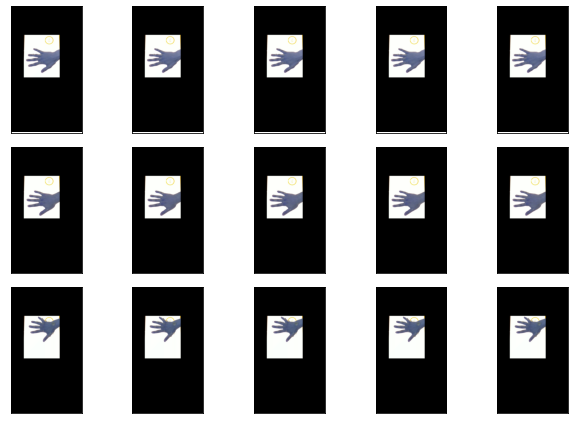

In [ ]:
def show_all_images(image_files):
  fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})
  for ax, image in zip(axs.flat, raw_images_right):
      ax.imshow(image)
  plt.tight_layout()
  plt.show()

show_all_images(raw_images_right)


./ROPCA_Vision/raw/left/img000001.png


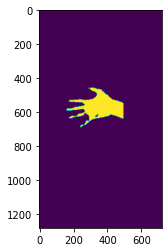

In [ ]:
def segment_image(folder, filename, hand_type):
  print(os.path.join(folder,filename))
  img = cv.imread(os.path.join(folder,filename),-1)

  #converting from gbr to hsv color space
  img_HSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #skin color range for hsv color space 
  HSV_mask = cv.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
  HSV_mask = cv.morphologyEx(HSV_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

  #converting from gbr to YCbCr color space
  img_YCrCb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    #skin color range for hsv color space
  YCrCb_mask = cv.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
  YCrCb_mask = cv.morphologyEx(YCrCb_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

  #merge skin detection (YCbCr and hsv)
  global_mask = cv.bitwise_and(YCrCb_mask,HSV_mask)
  global_mask = cv.medianBlur(global_mask,3)
  global_mask = cv.morphologyEx(global_mask, cv.MORPH_OPEN, np.ones((4,4), np.uint8))

  #Saves segmented image in specific folder with extracted file name.
  cv.imwrite("./ROPCA_Vision/segmented/"+ hand_type + "/" + filename ,global_mask)
  return global_mask

segmented_img = segment_image(data_folders_left[0],raw_files_left[0],'left')
plt.imshow(segmented_img)
plt.show()
#for i in raw_files_right:
#  segment_image("./ROPCA_Vision/raw/right/",i,"right")

#for i in raw_files_left:
  #segment_image("./ROPCA_Vision/raw/left/",i,"left") 

In [ ]:
def find_convex_hull(image):
  im = image
  gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY) # convert to grayscale
  blur = cv.blur(gray, (11, 11)) # blur the image
  ret, thresh = cv.threshold(blur, 50, 255, cv.THRESH_BINARY)

  contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  # create hull array for convex hull points
  hull = []

  # calculate points for each contour
  for i in range(len(contours)):
      # creating convex hull object for each contour
      hull.append(cv.convexHull(contours[i], False))

  drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)

  # draw contours and hull points
  for i in range(len(contours)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
    cv.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
    # draw ith convex hull object
    cv.drawContours(drawing, hull, i, color, 1, 8)

  #cv.imwrite("./ROPCA_Vision/convex/" + "01test_blur.png" ,blur)
  return drawing

#for i in raw_files_right:
#  drawing = find_convex_hull(cv.imread("./ROPCA_Vision/segmented/right/" + i))
#  cv.imwrite("./ROPCA_Vision/convex/right/" + i ,drawing)

#for i in raw_files_left:
#  drawing = find_convex_hull(cv.imread("./ROPCA_Vision/segmented/left/" + i))
#  cv.imwrite("./ROPCA_Vision/convex/left/" + i ,drawing)



In [ ]:
def drawAxis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    # [visualization1]
    angle = atan2(p[1] - q[1], p[0] - q[0])  # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) +
                      (p[0] - q[0]) * (p[0] - q[0]))

    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv.line(img, (int(p[0]), int(p[1])),
            (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)

    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv.line(img, (int(p[0]), int(p[1])),
            (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)

    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv.line(img, (int(p[0]), int(p[1])),
            (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
    # [visualization1]


def getOrientation(pts, img):
    # [pca]
    # Construct a buffer used by the pca analysis
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i, 0] = pts[i, 0, 0]
        data_pts[i, 1] = pts[i, 0, 1]

    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors = cv.PCACompute(data_pts, mean)

    # Store the center of the object
    cntr = (int(mean[0, 0]), int(mean[0, 1]))
    # [pca]

    # [visualization]
    # Draw the principal components
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    # p1 = (cntr[0] + 0.02 * eigenvectors[0, 0] * eigenvalues[0, 0],
    #       cntr[1] + 0.02 * eigenvectors[0, 1] * eigenvalues[0, 0])
    # p2 = (cntr[0] - 0.02 * eigenvectors[1, 0] * eigenvalues[1, 0],
    #       cntr[1] - 0.02 * eigenvectors[1, 1] * eigenvalues[1, 0])
    p1 = (cntr[0] + 0.02 * eigenvectors[0, 0] * 1000,
          cntr[1] + 0.02 * eigenvectors[0, 1] * 1000)
    p2 = (cntr[0] - 0.02 * eigenvectors[1, 0] * 1000,
          cntr[1] - 0.02 * eigenvectors[1, 1] * 1000)
    # drawAxis(img, cntr, p1, (0, 255, 0), 1)
    # drawAxis(img, cntr, p2, (255, 255, 0), 5)

    # orientation in radians
    angle = atan2(eigenvectors[0, 1], eigenvectors[0, 0])
    # [visualization]

    return angle

/content/drive/My Drive/summer_school_sdu
./ROPCA_Vision/raw/left/img000001.png
(1280, 720)


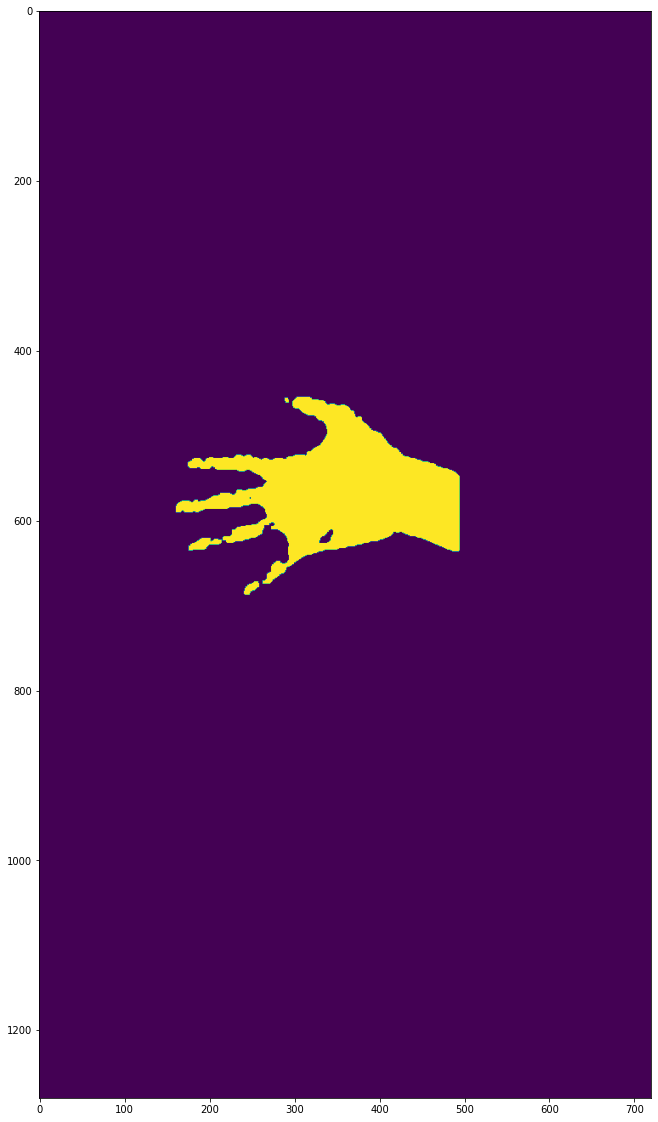

list

In [ ]:
!pwd
# [pre-process]
segmented_files_left = get_all_filenames(data_folders_left[2])
#segment_mask = cv.imread(os.path.join(data_folders_left[2],segmented_files_left[0]),cv.IMREAD_GRAYSCALE)
#segment_mask = segment_image(data_folders_left[0],segmented_files_left[0],'left')
np.max(segment_mask)
np.min(segment_mask)
_, bw = cv.threshold(segment_mask, 50, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

print(mask.shape)
plt.imshow(mask)
plt.show()

# [contours]
# Find all the contours in the thresholded image
contours,heirarchy = cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
type(contours)
#print(contours)

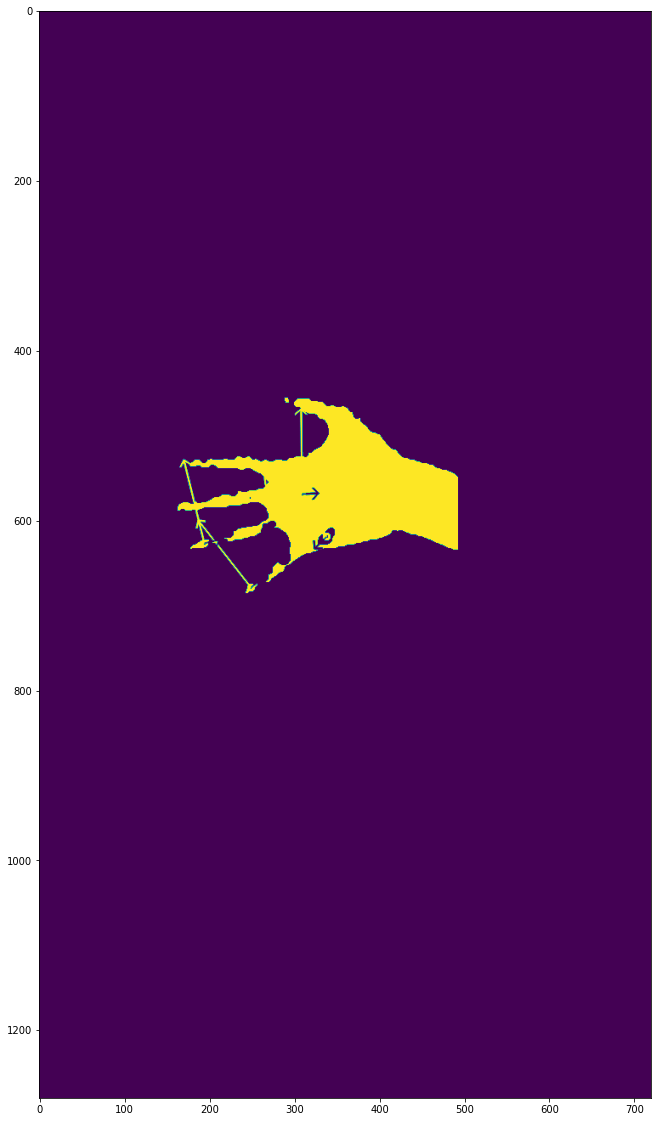

In [ ]:
for i, c in enumerate(contours):
    # Calculate the area of each contour
    #print(c)
    #area = cv.Moments(c)
    area = cv.contourArea(c)
    # Ignore contours that are too small or too large
    if area < 1e2 or 1e5 < area:
        continue

    # Draw each contour only for visualisation purposes
    #cv.drawContours(segment_mask, contours, i, (0, 0, 255), 2)
    # Find the orientation of each shape
    getOrientation(c, segment_mask)
# [contours]

plt.imshow(segment_mask)
plt.show()

